<a href="https://colab.research.google.com/github/Ashrafalaghbari/Mutivariate-long-term-forecasting-of-oil-production/blob/main/Multivariate_multistep_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout
from math import sqrt
import matplotlib.pyplot as plt

In [333]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [4]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [707]:
colum = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv')
colum.columns

Index(['DATEPRD', 'BORE_OIL_VOL', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P',
       'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'F_4_ON_STREAM_HRS', 'F_4_BORE_WI_VOL', 'F_5_ON_STREAM_HRS',
       'F_5_BORE_WI_VOL'],
      dtype='object')

In [708]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', usecols=["DATEPRD","BORE_OIL_VOL", 'ON_STREAM_HRS'],
                  parse_dates=["DATEPRD"], index_col="DATEPRD")

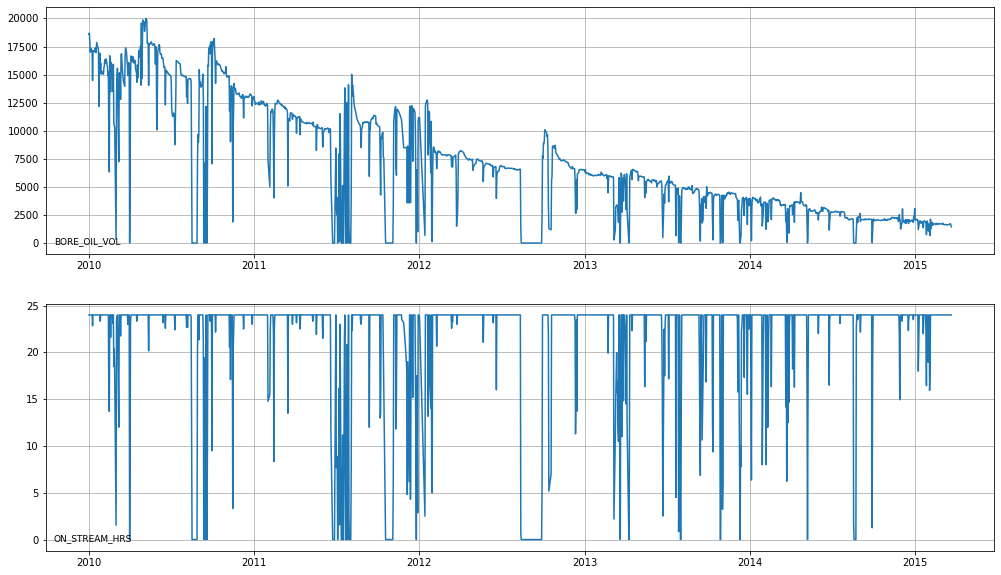

In [880]:
# Data visulaization and disribution plots for well F-14 after including the injectors
data = series.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 10))

axs = axs.ravel()

for id, column in enumerate(data):

    axs[id].plot(series[column])
    axs[id].grid(True)
    axs[id].legend([column], loc='lower left', fontsize=9, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

**Multi-output forecasting strategy**

In [1156]:
# # convert series to stationary
series_diff =  series.diff()
# convert the stationary series to supervise learning
timesteps = 5
steps_ahead = 1
# series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

In [1157]:
#drop all the variables that we don't want to predict
vars_y = series_supervised.columns[-steps_ahead*len(series.columns):]
vars_name_to_drop = ['ON_STREAM_HRS(t+)']
vars_to_drop = vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
series_supervised.drop(columns=vars_to_drop, inplace=True)

In [1158]:
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
ON_STREAM_HRS_t = series_supervised.pop('ON_STREAM_HRS(t)')
series_supervised.insert(len(series_supervised.columns)-1, 'ON_STREAM_HRS(t)', ON_STREAM_HRS_t)

In [1159]:
merged_onStreams = series_supervised["ON_STREAM_HRS(t-1)"] + (series_supervised["ON_STREAM_HRS(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_onStreams', merged_onStreams)

In [1163]:
series_supervised.drop(['ON_STREAM_HRS(t-1)','ON_STREAM_HRS(t)'], axis=1, inplace= True)

In [1164]:
series_supervised

,BORE_OIL_VOL(t-5),ON_STREAM_HRS(t-5),BORE_OIL_VOL(t-4),ON_STREAM_HRS(t-4),BORE_OIL_VOL(t-3),ON_STREAM_HRS(t-3),BORE_OIL_VOL(t-2),ON_STREAM_HRS(t-2),BORE_OIL_VOL(t-1),merged_onStreams,BORE_OIL_VOL(t)
DATEPRD,,,,,,,,,,,
2010-01-07,107.492863,0.0,-901.329859,0.0,-797.296392,0.0,268.323320,0.00000,60.822469,0.00000,-193.160084
2010-01-08,-901.329859,0.0,-797.296392,0.0,268.323320,0.0,60.822469,0.00000,-193.160084,0.00000,-10.944270
2010-01-09,-797.296392,0.0,268.323320,0.0,60.822469,0.0,-193.160084,0.00000,-10.944270,-1.16667,-2649.834308
2010-01-10,268.323320,0.0,60.822469,0.0,-193.160084,0.0,-10.944270,0.00000,-2649.834308,0.00000,2671.659950
2010-01-11,60.822469,0.0,-193.160084,0.0,-10.944270,0.0,-2649.834308,-1.16667,2671.659950,1.16667,-76.232504
...,...,...,...,...,...,...,...,...,...,...,...
2015-03-19,9.623410,0.0,-14.026278,0.0,16.605100,0.0,18.806534,0.00000,10.315289,0.00000,3.270702
2015-03-20,-14.026278,0.0,16.605100,0.0,18.806534,0.0,10.315289,0.00000,3.270702,0.00000,44.783451
2015-03-21,16.605100,0.0,18.806534,0.0,10.315289,0.0,3.270702,0.00000,44.783451,0.00000,17.925960


In [1165]:
series_supervised.columns

Index(['BORE_OIL_VOL(t-5)', 'ON_STREAM_HRS(t-5)', 'BORE_OIL_VOL(t-4)',
       'ON_STREAM_HRS(t-4)', 'BORE_OIL_VOL(t-3)', 'ON_STREAM_HRS(t-3)',
       'BORE_OIL_VOL(t-2)', 'ON_STREAM_HRS(t-2)', 'BORE_OIL_VOL(t-1)',
       'merged_onStreams', 'BORE_OIL_VOL(t)'],
      dtype='object')

In [1166]:
# split into train and test sets
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(1470, 11) (368, 11)


In [1167]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(1470, 11) (368, 11)


In [1168]:
# reshape input to be 3D [samples, timesteps, features]
n_features = len(series.columns) 

train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1470, 5, 2) (1470, 1) (368, 5, 2) (368, 1)


In [1169]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [4] 
n_epochs=18
batch_size=1

model = Sequential()
#model.add(LSTM(neurons[0], batch_input_shape=(batch_size, timesteps, n_features), stateful=True))
model.add(LSTM(neurons[0], input_shape=(timesteps, n_features)))
model.add(Dropout(0.3))
model.add(Dense(steps_ahead))
model.compile(loss='mean_squared_error', optimizer='adam')

from keras.callbacks import EarlyStopping
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
early_stop = EarlyStopping(monitor='loss', patience=4, verbose=1)
#model.reset_states()

Epoch 1/18
1470/1470 - 5s - loss: 0.0220 - val_loss: 2.3355e-04 - 5s/epoch - 4ms/step
Epoch 2/18
1470/1470 - 4s - loss: 0.0075 - val_loss: 2.5774e-04 - 4s/epoch - 2ms/step
Epoch 3/18
1470/1470 - 4s - loss: 0.0049 - val_loss: 1.9656e-04 - 4s/epoch - 2ms/step
Epoch 4/18
1470/1470 - 4s - loss: 0.0041 - val_loss: 2.1167e-04 - 4s/epoch - 2ms/step
Epoch 5/18
1470/1470 - 3s - loss: 0.0035 - val_loss: 2.9580e-04 - 3s/epoch - 2ms/step
Epoch 6/18
1470/1470 - 4s - loss: 0.0031 - val_loss: 3.8988e-04 - 4s/epoch - 2ms/step
Epoch 7/18
1470/1470 - 4s - loss: 0.0029 - val_loss: 4.0762e-04 - 4s/epoch - 2ms/step
Epoch 8/18
1470/1470 - 3s - loss: 0.0027 - val_loss: 4.5725e-04 - 3s/epoch - 2ms/step
Epoch 9/18
1470/1470 - 4s - loss: 0.0024 - val_loss: 5.1066e-04 - 4s/epoch - 3ms/step
Epoch 10/18
1470/1470 - 3s - loss: 0.0021 - val_loss: 5.0526e-04 - 3s/epoch - 2ms/step
Epoch 11/18
1470/1470 - 4s - loss: 0.0023 - val_loss: 4.3773e-04 - 4s/epoch - 2ms/step
Epoch 12/18
1470/1470 - 3s - loss: 0.0021 - val_loss

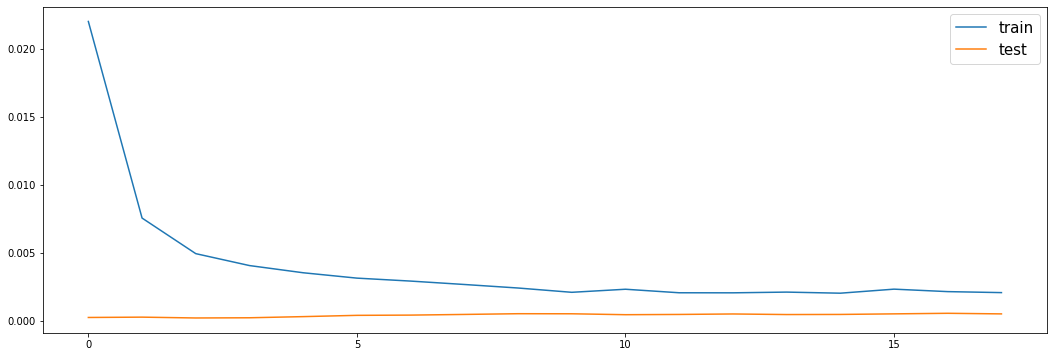

In [1170]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [1204]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:])


# invert scaling for actual
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat)
unscaled_df = pd.DataFrame(series_supervised)
new_max_value = 1 
new_min_value= 0

def transform_column(column):
    min_value = min(unscaled_df.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_df.iloc[:, -steps_ahead + column.name])
    feature_range = new_max_value - new_min_value
    return (np.multiply((max_value - min_value), (new_min_value + column)) + (feature_range  * min_value)) / feature_range 

inv_scale_y = scaled_y.apply(transform_column, axis=0)

# # # invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)


12/12 [==============================] - 0s 2ms/step


In [1205]:
inv_scale_yhat

,0
0,-33.466797
1,-2372.604492
2,818.561523
3,-2969.891602
4,-2663.767578
...,...
363,-13.266602
364,-8.807617
365,-30.199219
366,-22.316406


In [1206]:
inv_scale_y

,0
0,-42.833610
1,-1498.169987
2,815.096556
3,-2045.383509
4,-610.740609
...,...
363,3.270702
364,44.783451
365,17.925960
366,-104.788245


In [1196]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1,0]
#drop all the variables that we don't want to predict
agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [1212]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt)
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

current_timestep = 1
# actual value of oil rate at current time step
# steps_ahead = 4
#drop all the variables that we don't want to predict
vars_y = originalSeries_supervised.columns[-steps_ahead*len(series.columns):]
vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
originalSeries_supervised.drop(columns=vars_to_drop, inplace=True)
originalSeries_xt = originalSeries_supervised.iloc[-len(test):,-steps_ahead-1]


# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)
inv_yhat_cum = inv_yhat_cum.values

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].ravel()[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
col = pd.DataFrame.from_records(col) # creates a DataFrame from a list of records
#col.columns = pd.RangeIndex(start=1, stop=steps_ahead+1, step=1)
inv_yhat = col.to_numpy() # convert df to NumpyArray

In [1219]:
inv_yhat_cum[0:2]

array([[  -33.466797],
       [-2372.6045  ]], dtype=float32)

In [1218]:
originalSeries_xt[-n_obs:].ravel()[1]

1902.730604606

In [1213]:
inv_yhat 

array([[ 3367.4338  ],
       [ -469.8739  ],
       [ 3536.3887  ],
       [-2297.448   ],
       [-2602.0645  ],
       [ 6640.429   ],
       [  364.15662 ],
       [ 4508.9795  ],
       [  344.5395  ],
       [ 4422.282   ],
       [ 4203.2266  ],
       [ 3594.3208  ],
       [ 3516.833   ],
       [ 3404.8696  ],
       [ 3439.0718  ],
       [ 3365.2734  ],
       [ 1101.8274  ],
       [ 1924.3184  ],
       [ 4363.9434  ],
       [ 4275.1816  ],
       [  110.8374  ],
       [ 4746.9507  ],
       [ 4251.216   ],
       [ 3815.9324  ],
       [ 3793.3464  ],
       [ 3674.3357  ],
       [ 3688.5015  ],
       [ 3677.3447  ],
       [ 3612.2517  ],
       [ 3651.1255  ],
       [ 3612.583   ],
       [ 3631.1892  ],
       [ 3492.641   ],
       [ 3725.0356  ],
       [ 4425.0664  ],
       [ 3226.6897  ],
       [ 3930.6265  ],
       [ 3768.45    ],
       [ 3694.7202  ],
       [ 3512.1553  ],
       [ 3502.666   ],
       [ 3434.5173  ],
       [ 3389.0723  ],
       [ 33

In [1199]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

The Average scores for the vector output 1 steps ahead:

Test RMSE: 3474.27103
Test MAE: 3425.38344
Test r2: -50.73601
Test wMAPE: 99.62437 
Test SMAPE: 186.90627 


In [1001]:
Test RMSE: 555.56135
Test MAE: 277.11301
Test r2: 0.39641
Test wMAPE: 12.32902 
Test SMAPE: 17.45901

SyntaxError: ignored

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
inv_yhat

In [ ]:
inv_yhat[-1]

In [ ]:
plt.plot(inv_yhat[-1], label = "predicted")
plt.plot(inv_y[-1], label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [1055]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y.flatten(), "prediction":inv_yhat.flatten()})
act_pred.head(5)

,actual,prediction
0,3400.900591,3476.643311
1,1902.730605,3440.932861
2,2717.827160,2306.486328
3,672.443651,2784.086914
4,61.703042,1296.204346


In [1057]:
series_to_supervised(series, series.columns, n_in=2, n_out=steps_ahead, dropnan=True).iloc[-len(test):-len(test)+5]

,BORE_OIL_VOL(t-2),ON_STREAM_HRS(t-2),BORE_OIL_VOL(t-1),ON_STREAM_HRS(t-1),BORE_OIL_VOL(t),ON_STREAM_HRS(t)
DATEPRD,,,,,,
2014-03-21,3390.836894,24.00000,3443.734202,24.00000,3400.900591,24.00000
2014-03-22,3443.734202,24.00000,3400.900591,24.00000,1902.730605,14.16666
2014-03-23,3400.900591,24.00000,1902.730605,14.16666,2717.827160,24.00000
2014-03-24,1902.730605,14.16666,2717.827160,24.00000,672.443651,6.22500
2014-03-25,2717.827160,24.00000,672.443651,6.22500,61.703042,6.60833


In [1054]:
r2_score(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

-0.10745523798910495

In [1051]:
wMAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

61.34847727985786

In [1053]:
MAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

482.5886076465889